### ORBIT Example - Using HVDC or HVAC Example

Component or technology decisions have an impact on a wind project's CapEx. This example will provide a basic setup to compare how different project sizes, export cable types (HVDC or HVDC), distances to shore, etc. effect project costs, this is a very useful tool.

*NOTE: This example uses a test module: `ElectricalDesign` and therefore you must set your branch to dev*

### Import Dependencies

Include path to ORBIT repo and import parametric manager and any modules used for analysis. For this example, we will be running the `ElectricalDesign` module.

In [64]:
from ORBIT.phases.design import ElectricalDesign

from ORBIT import ProjectManager, ParametricManager

import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd

### Create Config

Config must include all required variables except those you plan to vary. In this example, we will be manually vary the cable type and then use the `ParametricManager` to vary cable type and plant capacity.

In [65]:
base_config = {
    'export_cable_install_vessel': 'example_cable_lay_vessel',
    'site': {
        'distance': 100,
        'depth': 20,
        'distance_to_landfall': 50
    },
    'plant': {
        'capacity': 1000
    },
    'turbine': "12MW_generic",
    'oss_install_vessel': 'example_heavy_lift_vessel',
    'feeder': 'future_feeder',
    'design_phases': [
        'ElectricalDesign',
    ],
    'install_phases': [
        'ExportCableInstallation',
        'OffshoreSubstationInstallation'
    ],

# Commented out because we will vary these manually
#     'export_system_design': {
#         'cables': 'XLPE_500mm_220kV',
#     }
}

### HVAC Export Cables

Add HVAC export cables to the config 

In [66]:
hvac_config = deepcopy(base_config)

hvac_config["export_system_design"] = {
            'cables': 'XLPE_1000mm_220kV',
     }

hvac_project = ProjectManager(hvac_config)
hvac_project.run()

print(f"Total CapEx per kW: ${hvac_project.total_capex_per_kw:.2f} ")

hvac_project.capex_breakdown

OffshoreSubstationInstallation:
Total CapEx per kW: $2507.12 


{'Export System': 301153600.0,
 'Offshore Substation': 47655941.13840648,
 'Export System Installation': 48563809.98096469,
 'Offshore Substation Installation': 3098929.2998477924,
 'Turbine': 1310400000,
 'Soft': 645000000,
 'Project': 151250000.0}

### HVDC Export Cables

Add HVDC export cables to the config

In [67]:
hvdc_config = deepcopy(base_config)

hvdc_config["export_system_design"] = {
            'cables': 'HVDC_2000mm_320kV',
     }

hvdc_project = ProjectManager(hvdc_config)
hvdc_project.run()

print(f"Total CapEx per kW: ${hvdc_project.total_capex_per_kw:.2f} ")

hvdc_project.capex_breakdown

OffshoreSubstationInstallation:
Total CapEx per kW: $2370.48 


{'Export System': 87801120.0,
 'Offshore Substation': 160151200.0,
 'Export System Installation': 12778131.303180292,
 'Offshore Substation Installation': 3098929.2998477924,
 'Turbine': 1310400000,
 'Soft': 645000000,
 'Project': 151250000.0}

## Use Parametric Manager to compare HVDC and HVAC
From the two examples above, we see that HVDC is more cost effective than HVAC. Note that the HVDC export system (cables) costs nearly 30% of the HVAC cables. However, the Offshore Substation (OSS) is over 3x the cost of an HVAC OSS. To compare this sensitivity and see if there is an point that these technologies cross we'll use `ParametricManager` and sweep each cable for a range of plant capacities. 

In [68]:
parameters = {
    'export_system_design.cables': ['XLPE_1000mm_220kV', 'HVDC_2000mm_320kV'],
    'plant.capacity': np.arange(100,2100,100)
}

### Define Outputs of Interest

Here in the results dictionary, define which variables you would like reported in the output data frame. 

In [69]:
results = {
    'cable_cost': lambda run: run.total_cable_cost,
    'oss_cost': lambda run: run.substation_cost,
    'num_cables': lambda run: run.num_cables,
    'num_substations': lambda run: run.num_substations,
}

### Run ParametricManager and See Results

In [90]:
parametric = ParametricManager(base_config, parameters, results, module = ElectricalDesign, product=True)
parametric.run()
parametric.results

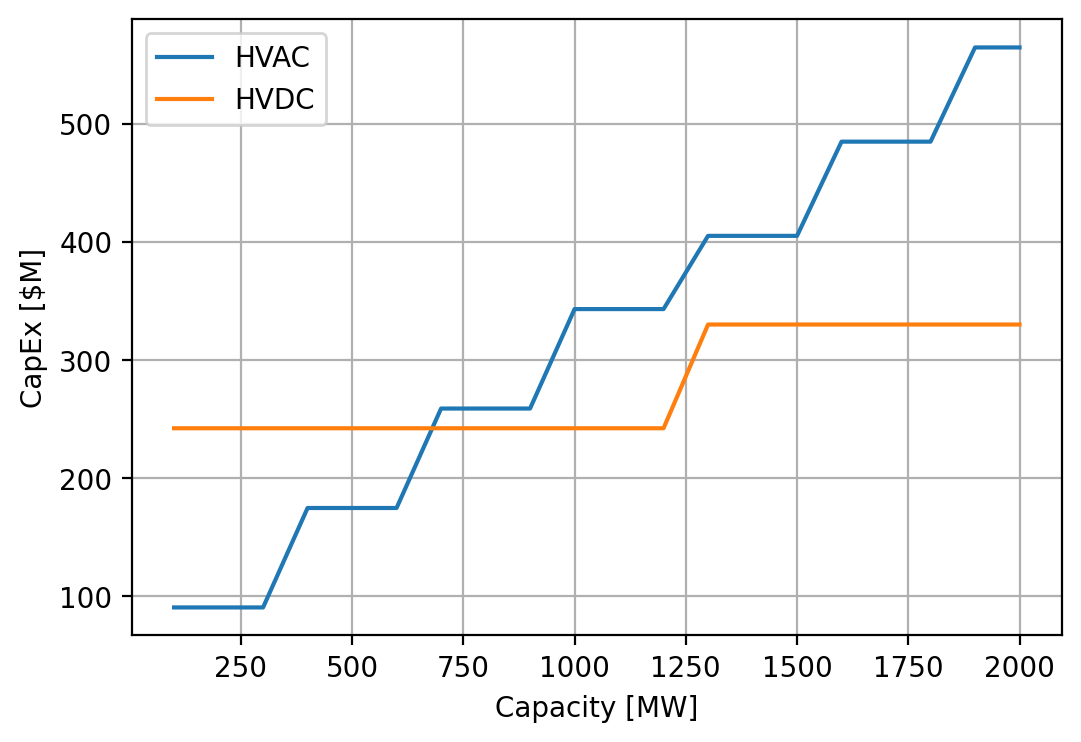

In [86]:
# Put results into a Dataframe
df = pd.DataFrame(parametric.results)

# Plot results
fig = plt.figure(figsize=(6,4), dpi=200)
ax = fig.subplots(1)

hvac_df = df[df['export_system_design.cables'] == 'XLPE_1000mm_220kV']
hvdc_df = df[df['export_system_design.cables'] == 'HVDC_2000mm_320kV']

ax.plot(hvac_df["plant.capacity"],
        (hvac_df["cable_cost"] + hvac_df["oss_cost"])/1e6,
        label='HVAC')

ax.plot(hvdc_df["plant.capacity"],
        (hvdc_df["cable_cost"] + hvdc_df["oss_cost"])/1e6,
        label='HVDC')

ax.set_ylabel("CapEx [$M]")
ax.set_xlabel("Capacity [MW]")
ax.legend()
ax.grid()


This plot shows that for a project that has less than 700MW of capacity you should use HVAC. But for projects greater than 700MW should use HVDC, if only considering the CapEx.